# Optimizer Example
Jena Climate ANN example showing the effects of dropout rates on the Adam optimizer.
This is a regression model, using 3-hour data

Gabriella Ferro & Richard Henry, 18-Jul-2024

In [1]:
#Import Libararies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Test Libraries

In [2]:
# Check python version
from platform import python_version
print(python_version())
#3.12.3

3.12.3


In [3]:
# Check tensorflow version
tf.__version__
#2.16.1

'2.16.2'

In [4]:
# Check keras version
tf.keras.__version__
#3.4.1

'3.4.1'

# Jena ANN

In [5]:
# Load Data (Already cleaned and decimated)
# Jupyter Notebook Edition
# df3=pd.read_csv('dataset/Jena_climate/cleanJena3.csv')

Adjustment for Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ls "/content/drive/MyDrive/DeepLearingGroup2/code/dataset/Jena_climate"

In [ ]:
df3=pd.read_csv('/content/drive/MyDrive/DeepLearingGroup2/code/dataset/Jena_climate/cleanJena.csv')

End Adjustment for Google Colab

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23363 entries, 0 to 23362
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   p (mbar)       23363 non-null  float64
 1   VPact (mbar)   23363 non-null  float64
 2   Tdew (degC)    23363 non-null  float64
 3   T (degC)       23363 non-null  float64
 4   max. wv (m/s)  23363 non-null  float64
 5   NSwind         23363 non-null  float64
 6   EWwind         23363 non-null  float64
 7   year           23363 non-null  int64  
 8   month          23363 non-null  int64  
 9   day            23363 non-null  int64  
 10  hour           23363 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 2.0 MB


In [7]:
df3.describe()

,p (mbar),VPact (mbar),Tdew (degC),T (degC),max. wv (m/s),NSwind,EWwind,year,month,day,hour
count,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000
mean,989.216246,9.533017,4.954671,9.456338,3.533382,-0.631798,-0.415655,2012.497068,6.517399,15.713222,10.500449
std,8.353071,4.184973,6.730860,8.428081,2.339862,1.983549,1.553730,2.289905,3.448433,8.799298,6.873702
min,942.720000,0.810000,-24.800000,-22.760000,0.000000,-10.783959,-7.148867,2009.000000,1.000000,1.000000,0.000000
25%,984.200000,6.220000,0.240000,3.340000,1.760000,-1.480647,-1.372670,2010.000000,4.000000,8.000000,6.000000
50%,989.590000,8.860000,5.210000,9.440000,2.980000,-0.637933,-0.296919,2012.000000,7.000000,16.000000,12.000000
75%,994.730000,12.360000,10.080000,15.480000,4.730000,0.306138,0.432981,2014.000000,10.000000,23.000000,15.000000
max,1015.170000,28.040000,22.940000,36.460000,18.780000,7.709359,6.966350,2017.000000,12.000000,31.000000,21.000000


In [8]:
# Model / data parameters
blk_len=16*8      #Look back at two weeks of data
stp_len=8         #look forward 24 hours
row_len=len(df3)   #total records (last target location)
col_len=11         #total variables
bat_len=64*8      #batch size of 2 months
epo_len=32         #32 epochs
val_fra=0.2        #use 20% of data for validation
pas_len=blk_len+stp_len  #first target location
cut_len=row_len-pas_len  #last start of predictor location
drop_01=0.2        #First dropout layer
drop_02=0.2        #Second dropout layer

In [9]:
%%time
# Reformat
y_train=df3['T (degC)'].iloc[pas_len:].to_numpy()  #pull out all the targets
#start building predictor deck
xAll=df3.to_numpy()
xTrain=np.zeros([cut_len,blk_len,col_len])
for i in range(cut_len):
    for j in range(blk_len):
            xTrain[i][j][:]=xAll[i+j][:]

CPU times: total: 2.47 s
Wall time: 2.61 s


In [10]:
#Normalize Input Data
fixMe=tf.keras.layers.Normalization()
fixMe.adapt(xTrain)

In [11]:
# Build & train model function
def model_build(drop1st,drop2nd):
    #Build it exactly the same every time
    tf.random.set_seed(19)
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(blk_len,col_len)),
            fixMe,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64,
                                  activation='relu'),
            tf.keras.layers.Dropout(drop1st),
            tf.keras.layers.Dense(32,
                                  activation='relu'),
            tf.keras.layers.Dropout(drop2nd),
            tf.keras.layers.Dense(1,
                                  activation='linear')
        ]
    )
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mean_absolute_error'])
    myHis=model.fit(xTrain,
                    y_train,
                    batch_size=bat_len,
                    epochs=epo_len,
                    validation_split=val_fra)
    myPre=model.predict(xTrain)
    return myHis,myPre

### First Model, Adam

In [12]:
%%time
h0,p0=model_build(drop_01,drop_02)

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 77.6881 - mean_absolute_error: 6.8973 - val_loss: 20.6006 - val_mean_absolute_error: 3.6433
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.4585 - mean_absolute_error: 3.8779 - val_loss: 15.6003 - val_mean_absolute_error: 3.1267
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.8160 - mean_absolute_error: 3.4949 - val_loss: 13.8940 - val_mean_absolute_error: 2.9406
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.5302 - mean_absolute_error: 3.2656 - val_loss: 13.0331 - val_mean_absolute_error: 2.8471
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.8156 - mean_absolute_error: 3.1085 - val_loss: 12.6440 - val_mean_absolute_error: 2.7937
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.8626 - mean_absolute_error: 3.0160 - val_loss: 12.8877 - val_mean_absolute_error: 2.8016
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.3544 - mean_absolute_error: 2.9655 - va

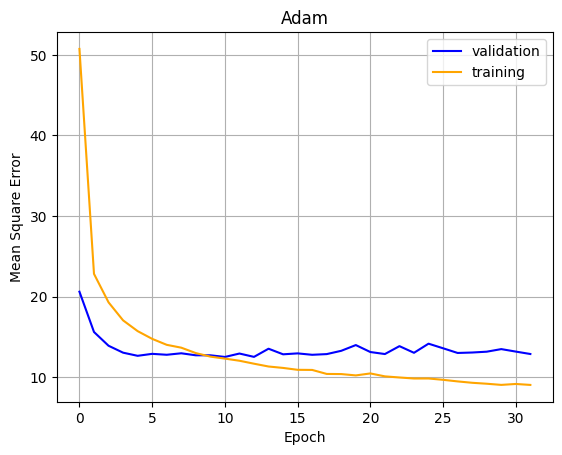

In [13]:
plt.plot(h0.history['val_loss'], color='blue')
plt.plot(h0.history['loss'], color='orange')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['validation','training'])
plt.title('Adam')
plt.grid()
plt.show()

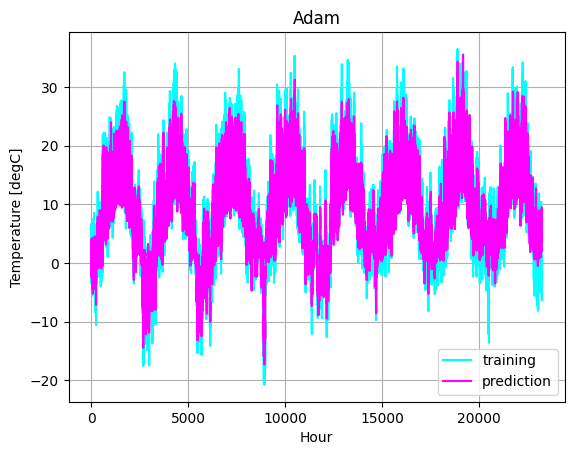

In [14]:
plt.plot(y_train, color='cyan')
plt.plot(p0.flatten(), color='magenta')
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam')
plt.grid()
plt.show()

In [15]:
#plt.plot(y_train, color='cyan')
#plt.plot(p0.flatten(), color='magenta')
#plt.ylabel('Temperature [degC]')
#plt.xlabel('Hour')
#plt.legend(['training','prediction'])
#plt.title('Adam (Final Year)')
#plt.grid()
#plt.xlim([60588,69348])
#plt.show()

In [16]:
#plt.plot(y_train, color='cyan')
#plt.plot(p0.flatten(), color='magenta')
#plt.ylabel('Temperature [degC]')
#plt.xlabel('Hour')
#plt.legend(['training','prediction'])
#plt.title('Adam (Final Month)')
#plt.grid()
#plt.xlim([68604,69348])
#plt.show()

In [17]:
#plt.plot(y_train, color='cyan')
#plt.plot(p0.flatten(), color='magenta')
#plt.ylabel('Temperature [degC]')
#plt.xlabel('Hour')
#plt.legend(['training','prediction'])
#plt.title('Adam (Final Week)')
#plt.grid()
#plt.xlim([69180,69348])
#plt.show()

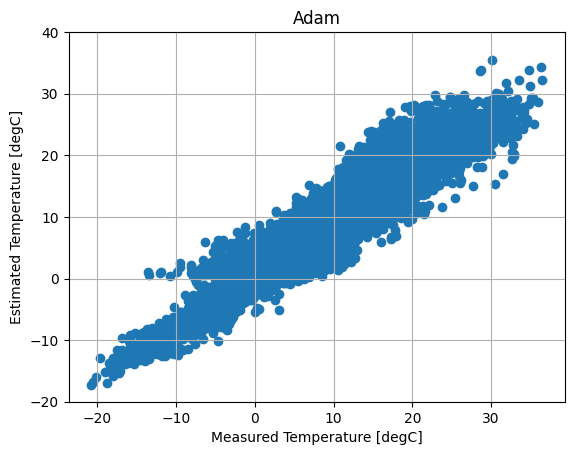

In [18]:
plt.scatter(y_train,p0.flatten())
plt.ylabel('Estimated Temperature [degC]')
plt.xlabel('Measured Temperature [degC]')
plt.title('Adam')
plt.grid()
plt.ylim([-20,40])
plt.show()

#### Commentary
Lorem Ipsum
### Second Model
Blah Blah Blah

In [19]:
%%time
h1,p1=model_build(0.2,0.4)

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 81.8305 - mean_absolute_error: 7.1006 - val_loss: 22.2936 - val_mean_absolute_error: 3.7572
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30.2309 - mean_absolute_error: 4.2714 - val_loss: 15.3816 - val_mean_absolute_error: 3.1195
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.4837 - mean_absolute_error: 3.7917 - val_loss: 14.0770 - val_mean_absolute_error: 2.9568
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.0763 - mean_absolute_error: 3.5763 - val_loss: 13.6835 - val_mean_absolute_error: 2.9110
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.6297 - mean_absolute_error: 3.4383 - val_loss: 12.9760 - val_mean_absolute_error: 2.8190
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.4590 - mean_absolute_error: 3.3441 - val_loss: 12.9941 - val_mean_absolute_error: 2.8162
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.6857 - mean_absolute_error: 3.2503 - va

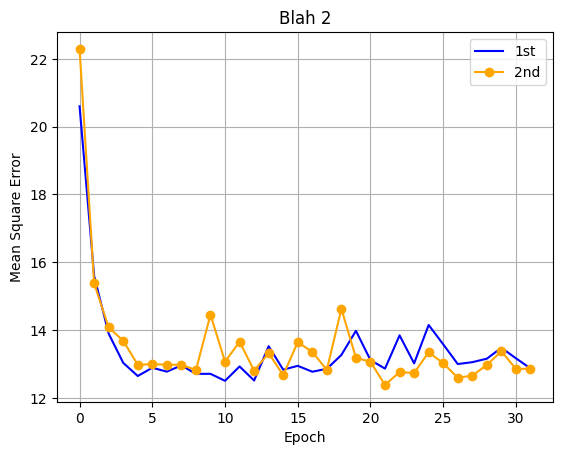

In [20]:
plt.plot(h0.history['val_loss'], color='blue')
plt.plot(h1.history['val_loss'], color='orange',marker='o')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['1st','2nd'])
plt.title('Blah 2')
plt.grid()
plt.show()

#### Commentary
Lorem Impsum
### Third Model
Blah Blah Blah

In [21]:
%%time
h2,p2=model_build(0.4,0.2)

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 83.4960 - mean_absolute_error: 7.1780 - val_loss: 19.7133 - val_mean_absolute_error: 3.5971
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.0929 - mean_absolute_error: 4.2168 - val_loss: 15.5895 - val_mean_absolute_error: 3.1249
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.8168 - mean_absolute_error: 3.8070 - val_loss: 14.7836 - val_mean_absolute_error: 3.0262
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.3729 - mean_absolute_error: 3.5521 - val_loss: 13.7479 - val_mean_absolute_error: 2.9146
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.7704 - mean_absolute_error: 3.4004 - val_loss: 13.1043 - val_mean_absolute_error: 2.8430
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.6069 - mean_absolute_error: 3.2735 - val_loss: 14.5681 - val_mean_absolute_error: 3.0107
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.1380 - mean_absolute_error: 3.2107 - va

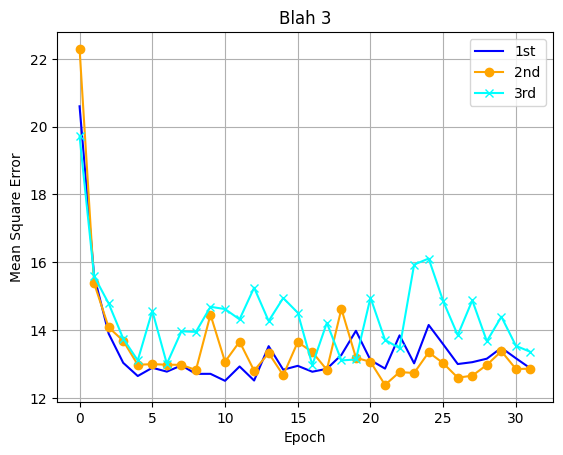

In [22]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['1st','2nd','3rd'])
plt.title('Blah 3')
plt.grid()
plt.show()

#### Commentary
Lorem Impsum
### Fourth Model
Blah Blah Blah

In [23]:
%%time
h3,p3=model_build(0.4,0.4)

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 76.9526 - mean_absolute_error: 6.8228 - val_loss: 20.0929 - val_mean_absolute_error: 3.5477
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 33.6186 - mean_absolute_error: 4.5573 - val_loss: 15.8443 - val_mean_absolute_error: 3.1483
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27.4929 - mean_absolute_error: 4.0882 - val_loss: 14.7866 - val_mean_absolute_error: 3.0173
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.3341 - mean_absolute_error: 3.8225 - val_loss: 13.4425 - val_mean_absolute_error: 2.9002
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.0250 - mean_absolute_error: 3.7197 - val_loss: 13.3790 - val_mean_absolute_error: 2.8822
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.7850 - mean_absolute_error: 3.6180 - val_loss: 12.6580 - val_mean_absolute_error: 2.7916
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.3174 - mean_absolute_error: 3.5706 - va

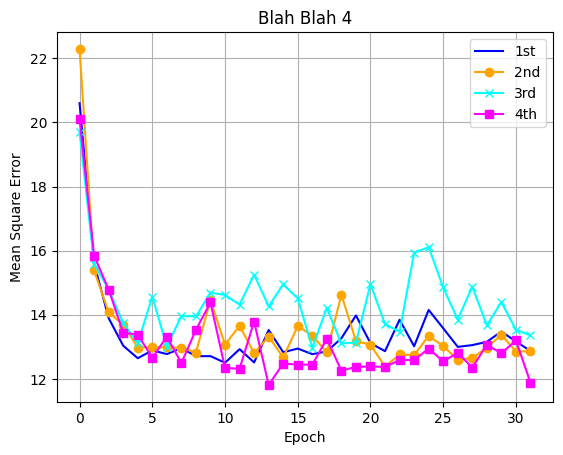

In [24]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.plot(h3.history['val_loss'],color='magenta',marker='s')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['1st','2nd','3rd','4th'])
plt.title('Blah Blah 4')
plt.grid()
plt.show()

#### Commentary
Lorem Ipsum
# Conclusions
Blah blah blah